In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.model_selection import StratifiedKFold

In [4]:
features_df = pd.read_csv('extracted_features_files/challange_2020-01-21 14:54:18.299172.csv')
#features_df.drop(['qrs_interval.1'], axis=1, inplace=True)
features_df.head()
#print(features_df['person'].value_counts())

,mean_q,mean_r,mean_s,stdev_q,stdev_r,stdev_s,mean_qrs_interval,mean_rr_interval,mean_rq_amplitude,person
0,-1.039036,0.409978,0.154258,0.022635,0.010087,0.019942,930.000000,1.449014,50.000000,tr14-0291
1,-0.631026,0.342097,0.162954,0.489841,0.070941,0.013946,430.000000,0.973123,61.666667,tr14-0291
2,-0.760507,0.372729,0.161926,0.512700,0.062801,0.024830,566.666667,1.133236,62.500000,tr14-0291
3,-1.079679,0.436452,0.169464,0.034610,0.020878,0.008969,920.000000,1.516131,52.500000,tr14-0291
4,-1.071868,0.458018,0.168823,0.008050,0.019041,0.001151,870.000000,1.529886,50.000000,tr14-0291


## Contagem de segmentos duplicados

In [5]:
#ecg_id_features.plot(figsize=(20,12))
print('total original:      ',len(features_df))
print('duplicados no original: ',sum(features_df.duplicated()))
print('número de pessoas únicas no original: ', features_df['person'].nunique())
features_df.drop_duplicates(keep='first', inplace=True)
print('total sem duplicados:      ',len(features_df))
print('duplicados no final: ',sum(features_df.duplicated()))
print('número de pessoas únicas sem dupicados: ', features_df['person'].nunique())

total original:       181552
duplicados no original:  10282
número de pessoas únicas no original:  1513
total sem duplicados:       171270
duplicados no final:  0
número de pessoas únicas sem dupicados:  1513


In [6]:
def remove_outliers(original_dataset, lower_threshold, upper_threshold, column_names=[]):
    ''' Remove outliers from a dataframe
        Everything above or below these percentiles will be cut off
    '''
    # TODO: add treatment for not numerical columns
    dataset = original_dataset.copy()
    
    if column_names:
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column
            #print(indexes_for_removal)
            dataset.drop(indexes_for_removal, inplace=True)
            #print(f'removed {len(indexes_for_removal)} outliers for column {column}')
            #print(f'remaining itens in dataset: {len(dataset)}')
        return dataset
            
    else:
        column_names = list(dataset.columns)
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column 
            dataset.drop(indexes_for_removal, inplace=True)
        return dataset
    
def remove(series, lower_threshold, upper_threshold):
    ''' Remove outliers from a single pandas Series '''
    # create a boolean mask where False values are the outliers
    removed_outliers = series.between(series.quantile(lower_threshold),
                                      series.quantile(upper_threshold))
    return removed_outliers

In [7]:
lower_threshold = 0.0025 # 0,025%
upper_threshold = 0.9975 # 0,025%

#lower_threshold = 0.02 # 1%
#upper_threshold = 0.98 # 1%

column_names = list(features_df.columns)
person_index = column_names.index('person')
column_names.pop(person_index)
print(f'Original features had {len(features_df)} rows')

cleaned_features_df = remove_outliers(features_df,lower_threshold, upper_threshold, column_names=column_names)

print(f'Features without outliers has {len(cleaned_features_df)} rows')

#cleaned_features_df.to_csv('driver_db_cleaned_features.csv', index=False)

Original features had 171270 rows
Features without outliers has 159938 rows


In [8]:
# Remove os rótulos
X = cleaned_features_df.drop(['person'], axis=1)
# Preenche os dados faltosos com a média da respectiva coluna
X = X.apply(lambda x: x.fillna(x.mean()))
# O objeto da predição é 'y' (os rótulos das classes)
y = cleaned_features_df['person']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Text(0.5, 1.0, 'Cumulative distribution of number of examples')

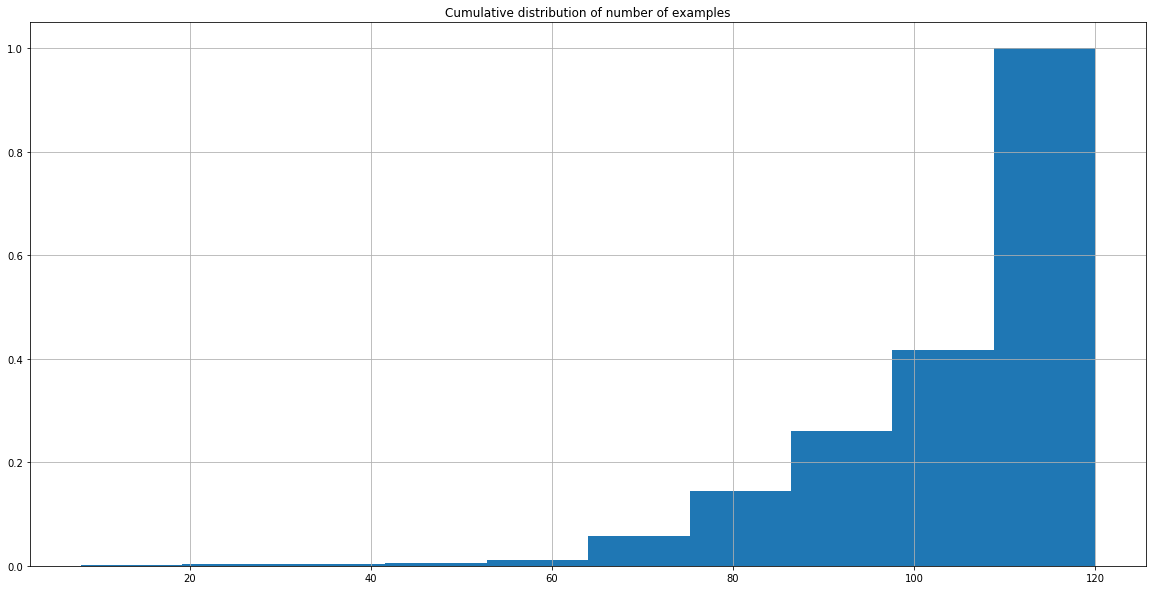

In [9]:
# filter_ = cleaned_features_df['person'].value_counts(ascending=True) >= 100
plt.figure(figsize=(20,10))
cleaned_features_df['person'].value_counts(ascending=True).hist(cumulative=True, density=1)
plt.title("Cumulative distribution of number of examples")

In [10]:
# se quisser obter as pessoas probleḿaticas
#print(list(cleaned_features_df['person'].value_counts(ascending=True)[:470].index))

['tr04-1023', 'te11-0559', 'tr05-0048', 'te09-0285', 'te05-0804', 'tr03-0567', 'te06-0395', 'tr12-0646', 'te06-0412', 'te03-1400', 'tr03-0418', 'tr03-0536', 'tr04-1096', 'tr11-0050', 'te04-0203', 'tr05-1457', 'te03-1216', 'tr04-0261', 'te03-1178', 'te09-0459', 'tr05-0857', 'tr05-0800', 'te09-0566', 'tr13-0164', 'te03-0805', 'te11-0601', 'tr05-1547', 'te12-0156', 'te09-0645', 'tr06-0812', 'tr12-0229', 'tr05-1258', 'tr11-0350', 'te10-0605', 'tr06-0721', 'te09-0605', 'te07-0749', 'tr14-0185', 'tr07-0257', 'te12-0256', 'tr05-1121', 'tr09-0122', 'te11-0167', 'tr04-0931', 'te04-0543', 'tr04-0120', 'te03-0750', 'te12-0653', 'te05-1073', 'te09-0634', 'tr10-0626', 'tr05-0256', 'tr05-1317', 'te12-0180', 'tr03-1010', 'te05-1141', 'tr05-1464', 'te03-1117', 'te05-0088', 'tr04-0079', 'te13-0574', 'te12-0660', 'te05-1249', 'tr11-0101', 'te05-0255', 'tr03-0713', 'te09-0121', 'te09-0481', 'tr04-0878', 'tr03-1371', 'tr11-0659', 'tr04-0121', 'tr13-0076', 'te12-0498', 'tr08-0192', 'tr04-0030', 'te07-0270'

In [11]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
print(skf)

prediction_list = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestClassifier(n_jobs=4, n_estimators=200, max_depth=100, min_samples_leaf=3, min_samples_split=10, verbose=True)
    rf.fit(X_train, y_train)
    predictions = rf.pŕedict(y_test)
    classification_output = classification_report(y_test, predictions)
    print(classification_output)
    prediction_list.append(classification_output)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 